In [5]:
import utils
import loader
import graphics

from itertools import product

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

# Se usan las trazas de Simva o las de Scorm
use_scorm = False

files_path = "./trazas/simva/"
cols_to_drop = ["stored", "id", "version", "actor.account.homePage", "authority.name", "authority.homePage", "context.contextActivities.category", "context.registration", "object.definition.name.en-US", "object.definition.description.en-US", "object.definition.type", "verb.display.en-US", "verb.id", "object.objectType", "result.response", "result.score.scaled", "result.completion", "result.success"]

if use_scorm:
	files_path = "./trazas/scorm/"
	cols_to_drop = ["verb.display.en-US", "id", "stored", "version", "actor.objectType", "actor.account.homePage", "result.success", "result.completion", "context.registration", "authority.objectType", "authority.account.homePage", "authority.account.name", "authority.name", "object.definition.description.en-US", "object.definition.name.en-US", "object.objectType", "context.contextActivities.category"]

files_extension = "json"


############################
# Datos comunes
# Sacado de los JSONs
############################
all_users_df, users_individual_df_list = loader.load_all_files(files_path, files_extension, "timestamp", cols_to_drop, use_scorm)
n_users = len(users_individual_df_list)

game_starts_conditions = [('object.id', 'GameStart')]
game_starts = utils.find_indices_by_conditions(all_users_df, game_starts_conditions)
game_starts = all_users_df.iloc[game_starts]
game_starts = game_starts.drop_duplicates(subset=["actor.account.name"])

col1 = game_starts['Gender'].unique()
col2 = game_starts['Sexuality'].unique()
gender_sexuality_combinations = list(product(col1, col2))

demography = game_starts[['actor.account.name', 'Gender', 'Sexuality']].values.tolist()

demography_info = {}
for user in demography:
	demography_info.update({user[0]: (user[1], user[2])})

#####################
APARTADO 1 a i y 1 b i
Porcentaje de elección de las diferentes respuestas cuando se presentan varias opciones en las siguientes situaciones
Porcentaje de elección de las diferentes respuestas en base a los datos demográficos recogidos al inicio del juego:

Nodo Scene1Bedroom1.computer1.choices:
   Contestar más friamente.: 33.33333333333333%
   	('male', 'heterosexual'): 100.0%
   	('male', 'homosexual'): 0.0%
   	('male', 'bisexual'): 0.0%
   	('female', 'heterosexual'): 0.0%
   	('female', 'homosexual'): 0.0%
   	('female', 'bisexual'): 0.0%
   Contestar amablemente.: 66.66666666666666%
   	('male', 'heterosexual'): 0.0%
   	('male', 'homosexual'): 0.0%
   	('male', 'bisexual'): 50.0%
   	('female', 'heterosexual'): 0.0%
   	('female', 'homosexual'): 50.0%
   	('female', 'bisexual'): 0.0%

Nodo Scene1Bedroom1.computer2.choices3:
   Me voy ya, que es tarde: 66.66666666666666%
   	('male', 'heterosexual'): 50.0%
   	('male', 'homosexual'): 0.0%
   	('male', 'bise

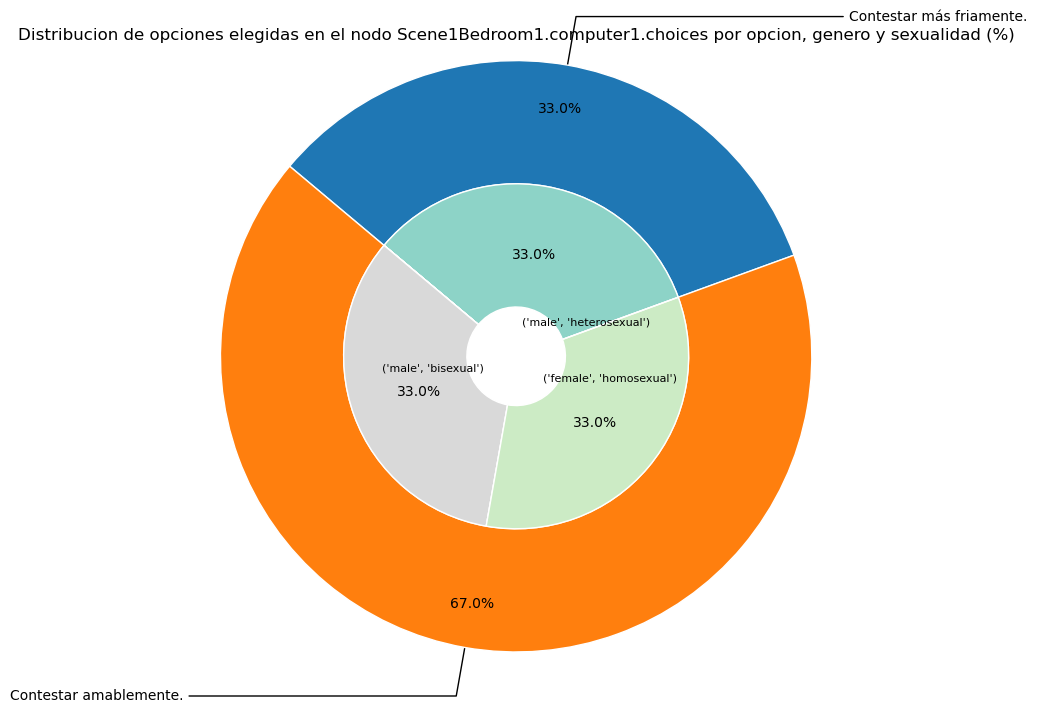

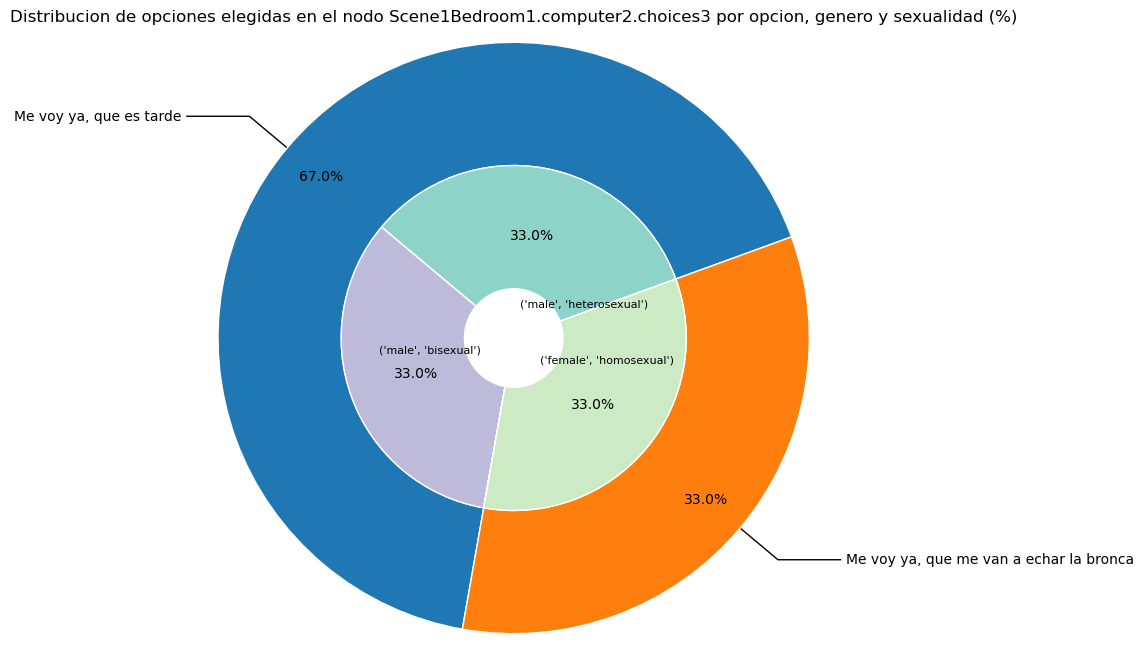

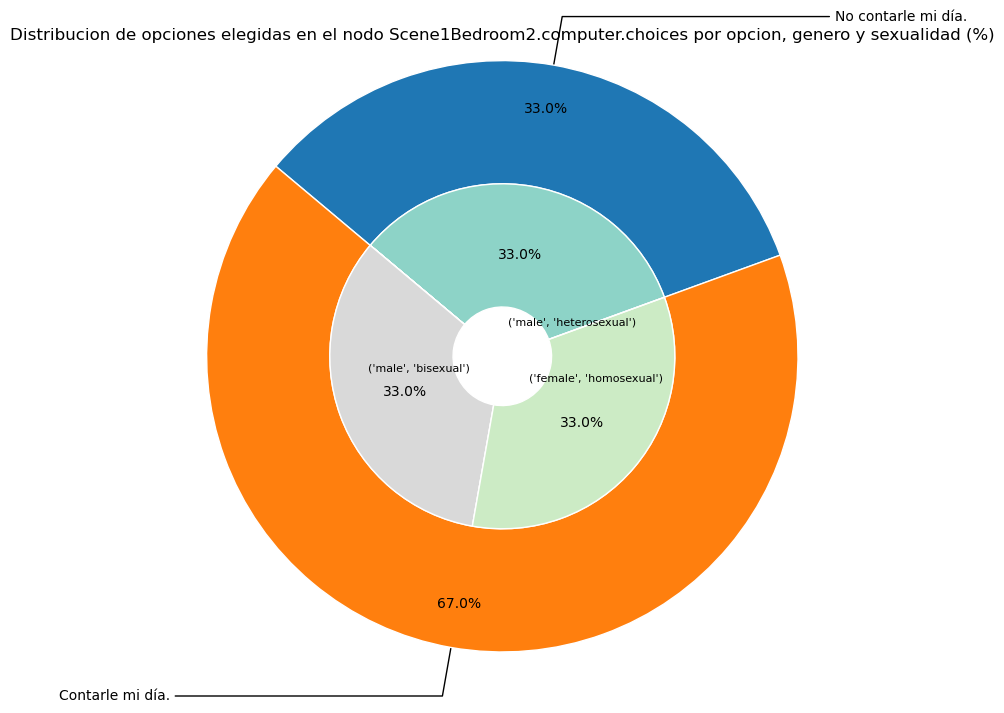

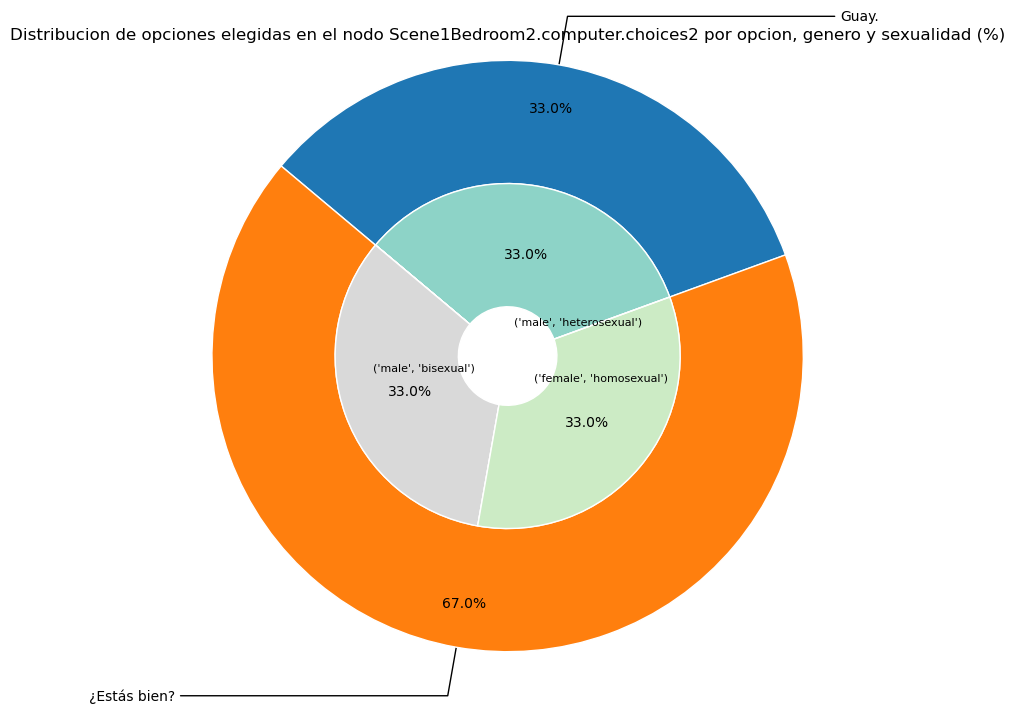

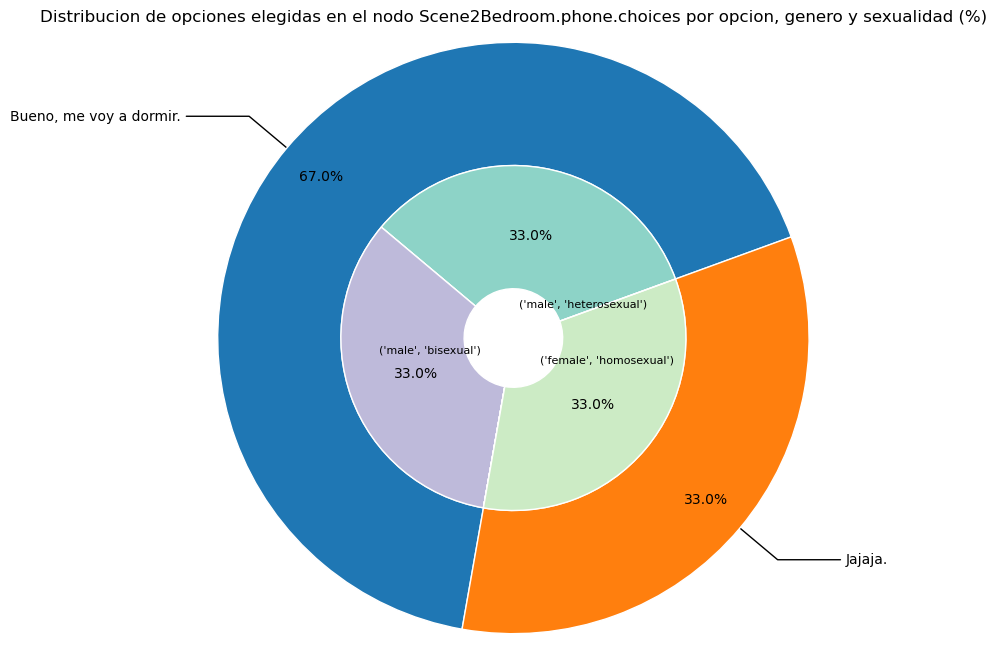

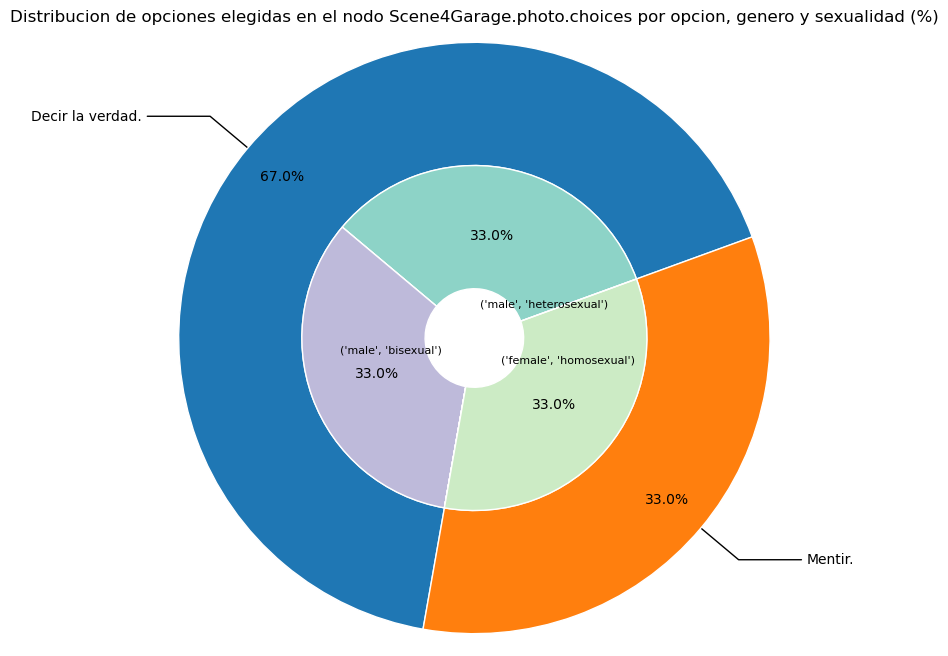

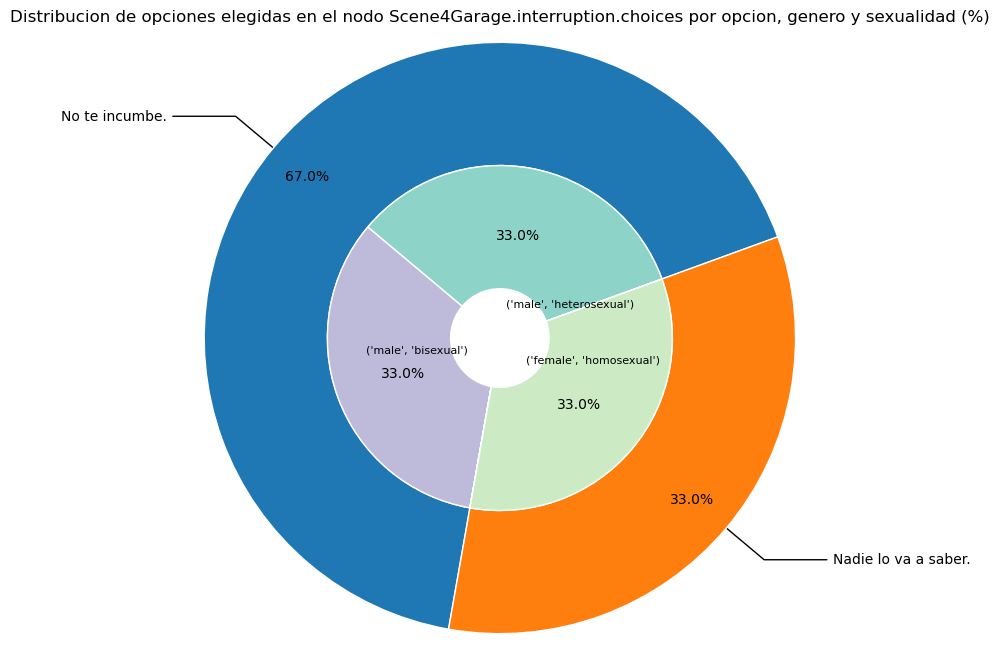

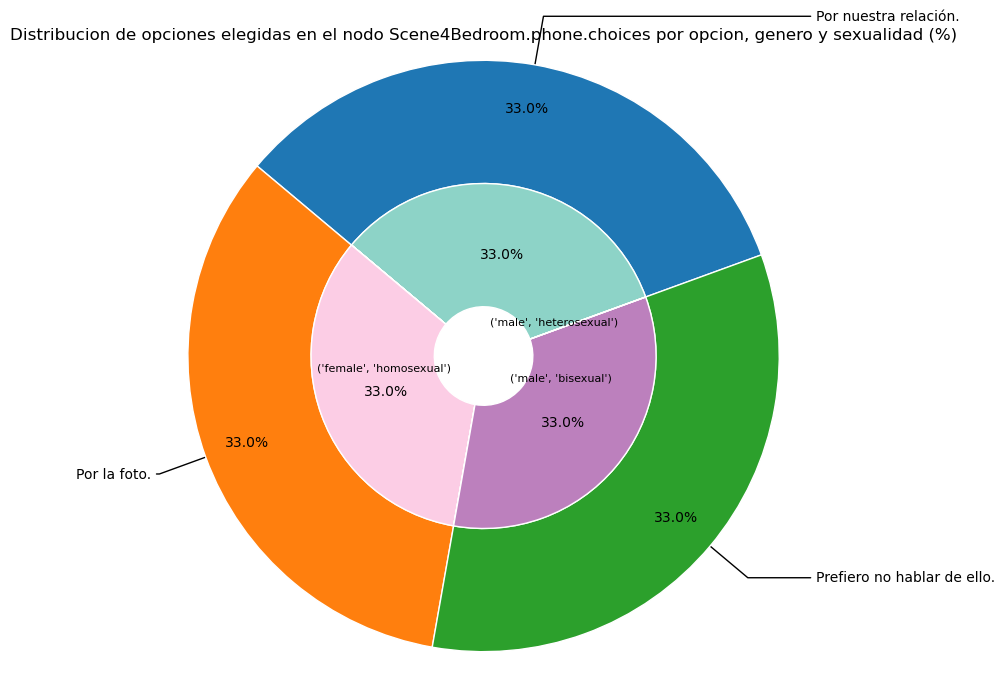

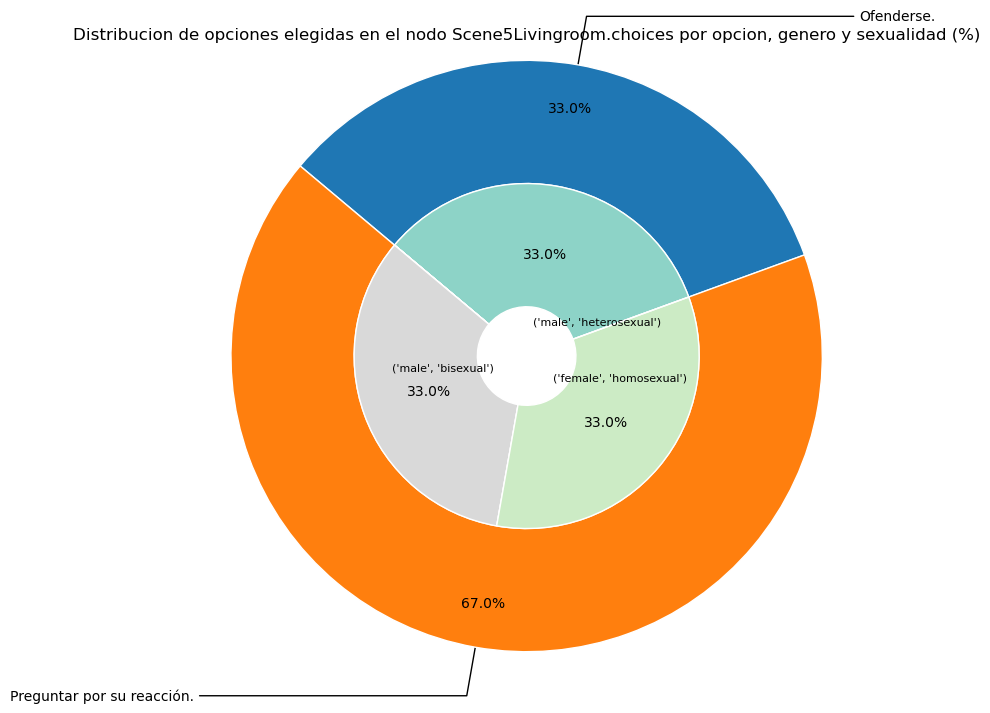

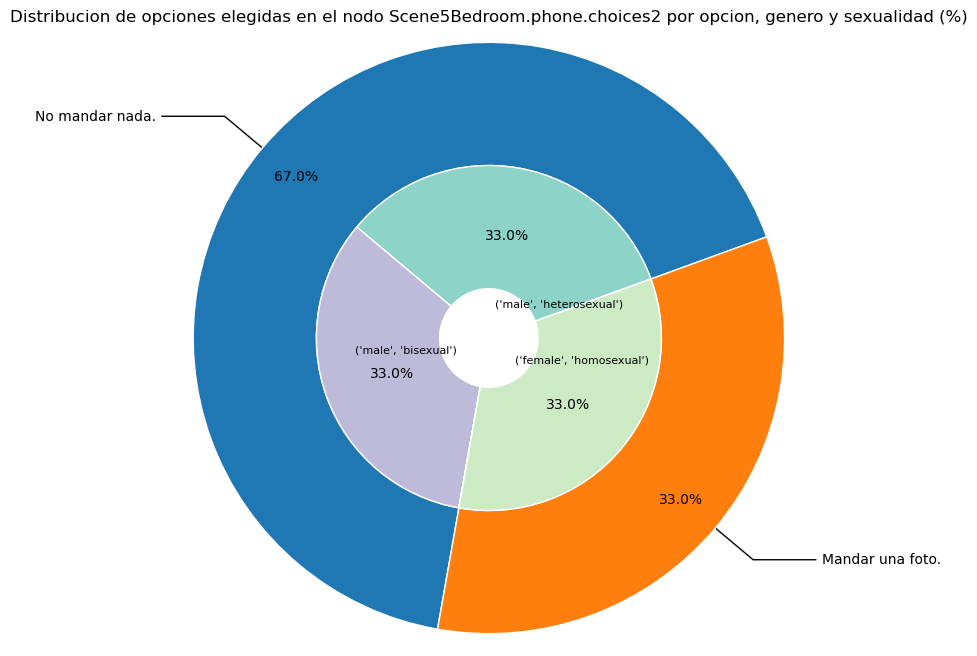

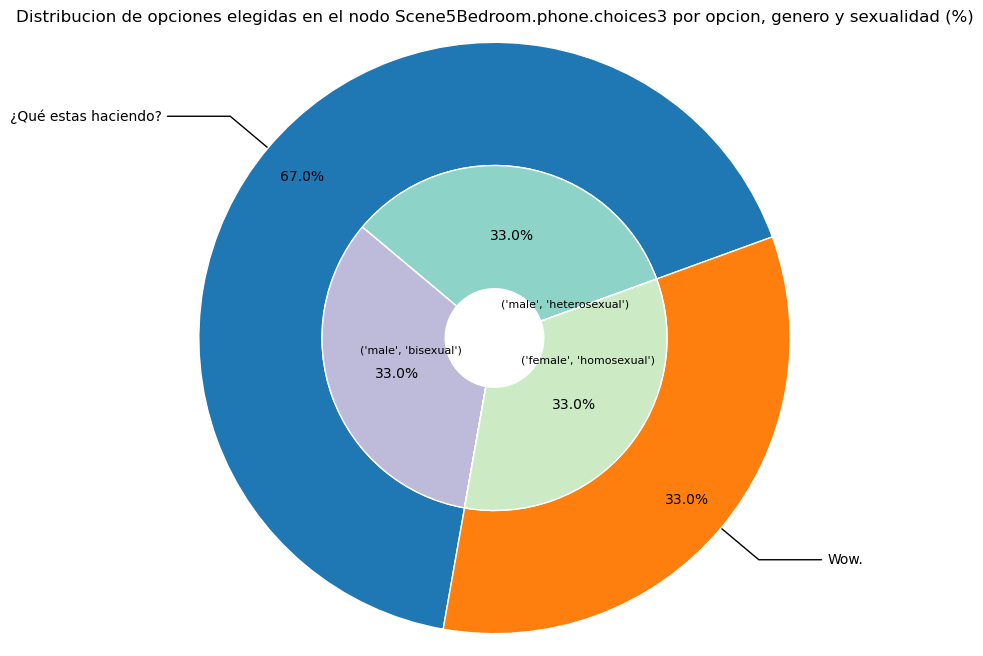

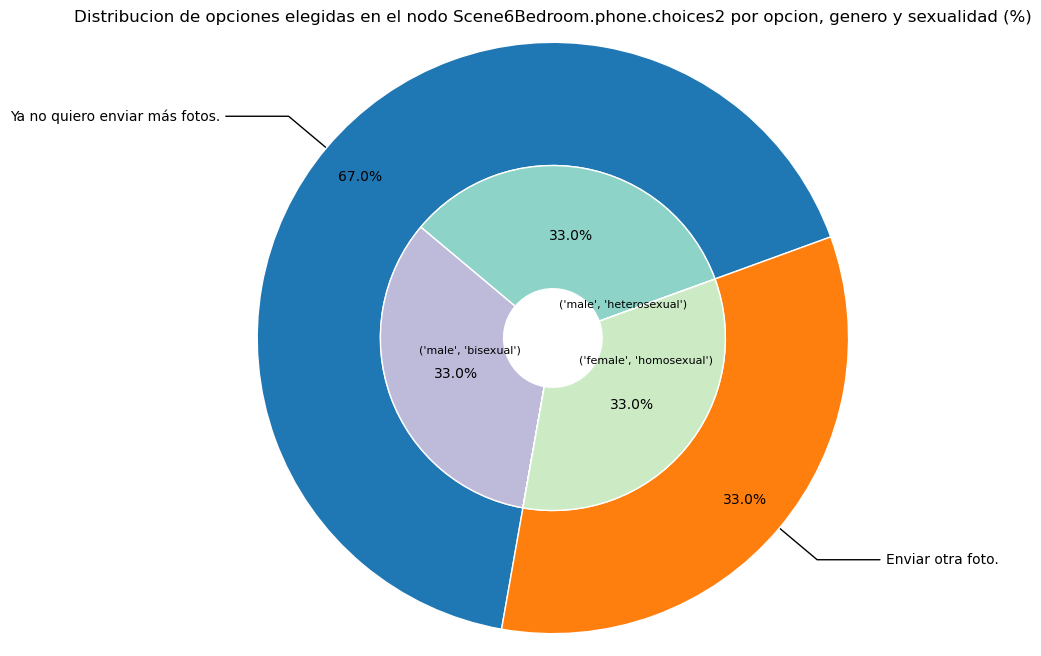

#####################
APARTADO 1 a ii y 1 b ii
Porcentaje de obtención de cada final.
Porcentaje de obtención de cada final en base a los datos demográficos recogidos al inicio del juego:

routeB_explained: 66.66666666666666%
   ('male', 'heterosexual'): 50.0%
   ('male', 'homosexual'): 0.0%
   ('male', 'bisexual'): 50.0%
   ('female', 'heterosexual'): 0.0%
   ('female', 'homosexual'): 0.0%
   ('female', 'bisexual'): 0.0%

routeA: 33.33333333333333%
   ('male', 'heterosexual'): 0.0%
   ('male', 'homosexual'): 0.0%
   ('male', 'bisexual'): 0.0%
   ('female', 'heterosexual'): 0.0%
   ('female', 'homosexual'): 100.0%
   ('female', 'bisexual'): 0.0%


#####################



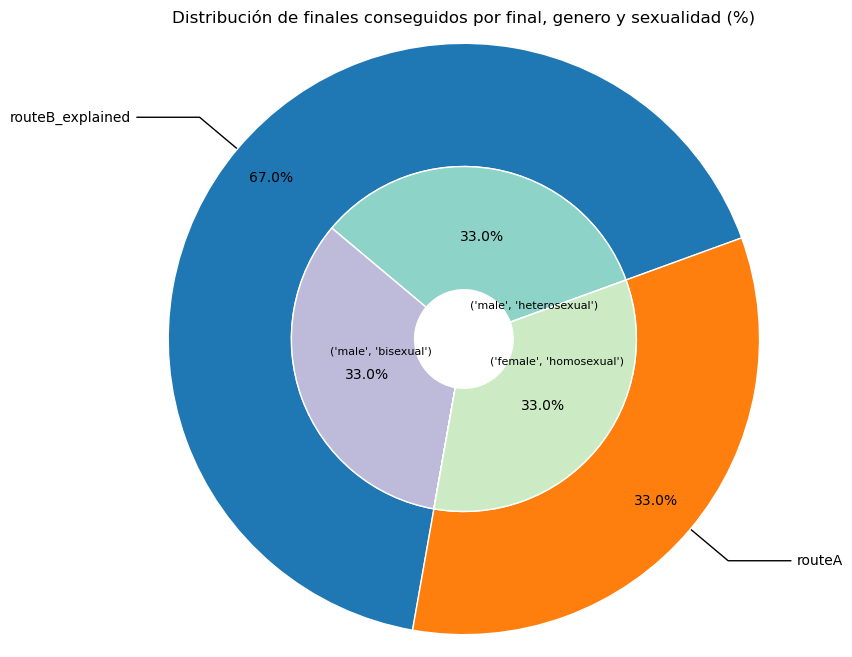